In [1]:
import numpy as np
import pandas as pd
import torch 

seed=23
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
from fastai.tabular.all import *
from pyxtend import struct
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


df = pd.read_csv('./dataset/train.csv')
test_df = pd.read_csv('./dataset/test.csv')
df = df.drop(['ID'], axis=1)
test_df = test_df.drop(['ID'], axis=1)
df.head()

/Users/kartiksinghal/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,...,n4087,n4088,n4089,n4090,n4091,n4092,n4093,n4094,n4095,category
0,0.0,0.000000,1.272801,0.290501,0.581446,0.000000,0.000000,0,0.000000,0.0,...,1.645888,0.869640,0.302432,0.953719,0.022545,0.498048,0.0,0.034988,0.692382,Orange_Ripe
1,0.0,0.000000,1.542096,0.000000,0.896557,0.049978,0.000000,0,0.117847,0.0,...,1.504220,0.622686,0.588427,0.524415,0.305426,0.386204,0.0,0.000000,0.668196,Banana_Ripe
2,0.0,0.000000,1.098595,0.571866,0.500355,0.000000,0.000000,0,0.493137,0.0,...,1.169341,0.913239,0.064404,0.531270,0.000000,0.471604,0.0,0.000000,0.658250,Mango_Raw
3,0.0,0.101666,1.159194,0.599216,0.893206,0.000000,0.200139,0,0.645675,0.0,...,0.560686,1.243676,0.432523,0.701881,0.000000,0.589985,0.0,0.000000,0.591165,Leeche_Raw
4,0.0,0.000000,1.178603,0.362568,0.577602,0.000000,0.000000,0,0.079862,0.0,...,1.206032,0.736831,0.345906,0.878515,0.119000,0.261441,0.0,0.000000,0.458905,Mango_Ripe


In [3]:
dep_var = 'category'

continuous_vars, categorical_vars = cont_cat_split(df, dep_var=dep_var)
waste_cont_features = np.array(continuous_vars)[df.loc[:,continuous_vars].nunique() == 1]
waste_cat_features = np.array(categorical_vars)[df.loc[:,categorical_vars].nunique() == 1]

# No waste cont features
df = df.drop(waste_cat_features, axis=1)
test_df = test_df.drop(waste_cat_features, axis=1)

In [4]:
continuous_vars, categorical_vars = cont_cat_split(df, dep_var=dep_var)

In [5]:
# train_df, val_df = train_test_split(df, random_state=seed)
splits = RandomSplitter(valid_pct=0.2)(range_of(df))
preprocessing = [Normalize]


In [6]:
df_wrapper = TabularPandas(df, procs=preprocessing, cont_names=continuous_vars,
                   y_names=dep_var, splits=splits)

test_df_wrapper = TabularPandas(test_df, procs=preprocessing, cont_names=continuous_vars)

In [7]:
batch_size = 32
dls = df_wrapper.dataloaders(bs=batch_size)
test_dls = test_df_wrapper.dataloaders(bs=batch_size)
batch = next(iter(dls.train))
len(batch)


3

In [8]:
cat_vars, cont_vars, labels = batch
cont_vars[:5], labels[:5]


(tensor([[-0.1039, -0.4847,  0.1130,  ..., -0.0816,  0.3942,  1.4329],
         [-0.1039, -0.4847,  0.2673,  ..., -0.0816, -0.4473, -0.1969],
         [-0.1039, -0.4847,  0.4806,  ..., -0.0816,  0.5522,  0.3965],
         [-0.1039,  0.5430, -0.3913,  ..., -0.0816, -0.4473, -1.2309],
         [-0.1039,  0.2210,  0.2876,  ..., -0.0816, -0.4473, -0.2016]]),
 tensor([[15],
         [10],
         [15],
         [14],
         [18]], dtype=torch.int8))

SuggestedLRs(valley=0.0008317637839354575)

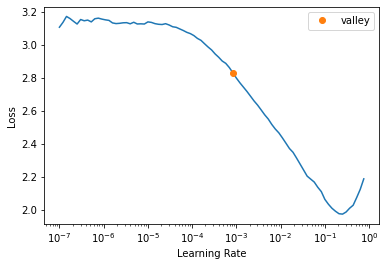

In [9]:
learn = tabular_learner(dls, layers=[64], metrics=accuracy)
learn.lr_find() 

In [10]:
learn.fit(10, 0.0008317637839354575)

In [11]:
learn.show_results()


In [12]:
learn.summary()


TabularModel (Input shape: 32 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 3621           
BatchNorm1d                               7242       True      
____________________________________________________________________________
                     32 x 64             
Linear                                    231744     True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     32 x 20             
Linear                                    1300       True      
____________________________________________________________________________

Total params: 240,414
Total trainable params: 240,414
Total non-trainable params: 0

Optimizer used: <function Adam at 0x1764b1550>
Loss function: FlattenedLoss of CrossEntropyLoss()

Model unfrozen

Callbacks:
  - TrainEva

In [13]:
test_dl = dls.test_dl(test_df)
preds = learn.get_preds(dl=test_dl)


In [14]:
idx_labels = torch.argmax(preds[0], axis=1)

In [15]:
string_labels = [dls.vocab [int(pred)] for pred in idx_labels.tolist()]
string_labels

['Leeche_Raw',
 'Orange_Raw',
 'Pomengranate_Ripe',
 'Strawberry_Raw',
 'Orange_Ripe',
 'Banana_Ripe',
 'Coconut_Ripe',
 'Apple_Ripe',
 'Coconut_Ripe',
 'Coconut_Ripe',
 'Strawberry_Ripe',
 'Banana_Ripe',
 'Mango_Raw',
 'Papaya_Ripe',
 'Guava_Ripe',
 'Mango_Ripe',
 'Orange_Raw',
 'Banana_Raw',
 'Papaya_Ripe',
 'Mango_Raw',
 'Guava_Raw',
 'Banana_Ripe',
 'Pomengranate_Ripe',
 'Pomengranate_Raw',
 'Papaya_Ripe',
 'Strawberry_Ripe',
 'Apple_Raw',
 'Orange_Ripe',
 'Coconut_Ripe',
 'Orange_Ripe',
 'Banana_Ripe',
 'Apple_Ripe',
 'Leeche_Raw',
 'Banana_Raw',
 'Mango_Raw',
 'Coconut_Raw',
 'Apple_Ripe',
 'Orange_Raw',
 'Orange_Raw',
 'Pomengranate_Ripe',
 'Guava_Raw',
 'Papaya_Raw',
 'Leeche_Raw',
 'Papaya_Ripe',
 'Apple_Ripe',
 'Apple_Ripe',
 'Leeche_Raw',
 'Orange_Raw',
 'Banana_Ripe',
 'Papaya_Ripe',
 'Papaya_Raw',
 'Mango_Ripe',
 'Mango_Raw',
 'Mango_Ripe',
 'Apple_Ripe',
 'Leeche_Ripe',
 'Papaya_Ripe',
 'Mango_Raw',
 'Coconut_Raw',
 'Strawberry_Ripe',
 'Banana_Ripe',
 'Guava_Raw',
 'Apple

In [ ]:
# test_df = pd.read_csv('./dataset/test.csv')

# IDs = test_df.loc[:,"ID"]
# test_df = test_df.drop(['ID'], axis=1)


In [ ]:
# size = len(df)
# random_idx = np.random.permutation(range(size))
# train_df = df[random_idx[:0.8*size]]
# val_df = df[random_idx[0.8*size:]]

In [16]:
output_data = {'ID': range(len(string_labels)),
        'Category': string_labels}

In [17]:
output_df = pd.DataFrame(output_data)
output_df

,ID,Category
0,0,Leeche_Raw
1,1,Orange_Raw
2,2,Pomengranate_Ripe
3,3,Strawberry_Raw
4,4,Orange_Ripe
...,...,...
410,410,Orange_Ripe
411,411,Mango_Ripe
412,412,Banana_Ripe
413,413,Mango_Raw


In [18]:
output_df.to_csv('file2.csv', index=False)